In [1]:
!pip install onnxruntime

     ---------------------------------------- 5.9/5.9 MB 1.8 MB/s eta 0:00:00
     ---------------------------------------- 46.0/46.0 kB 2.4 MB/s eta 0:00:00
     ---------------------------------------- 86.8/86.8 kB 1.7 MB/s eta 0:00:00
     ---------------------------------------- 95.2/95.2 kB 1.8 MB/s eta 0:00:00


In [2]:
import os
import torch
import torch.nn as nn
from itertools import chain
import random
import onnxruntime as onnxrt
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import torchvision.transforms as tt
from PIL import Image

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Модели

In [5]:
class ImagePool:
    def __init__(self, size):
        self.size = size
        self.images = []

    def query(self, images):
        if self.size == 0:
            return images
        return_images = []
        for image in images:
            image = torch.unsqueeze(image.data, 0)
            if len(self.images) < self.size:
                self.images.append(image)
                return_images.append(image)
            else:
                p = random.random()
                if p < 0.5:
                    ind = random.randrange(self.size)
                    return_images.append(self.images[ind].clone())
                    self.images[ind] = image
                else:
                    return_images.append(image)
        return torch.cat(return_images, 0)

In [7]:
class PatchGAN(nn.Module):
    def __init__(self, in_channels=3):
        super(PatchGAN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1, bias=True),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=True),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=True),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1, bias=True),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1, bias=True)
        )
        
    def forward(self, x):
        return self.model(x)

In [8]:
class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super(ResnetBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=False),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=False),
            nn.BatchNorm2d(dim),
        )

    def forward(self, x):
        return x + self.block(x)
        
class ResnetGenerator(nn.Module):
    def __init__(self, n_blocks=6):
        super(ResnetGenerator, self).__init__()
        
        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(3, 64, kernel_size=7, padding=0, bias=False),
                 nn.BatchNorm2d(64),
                 nn.ReLU(True)]

        # downsampling
        model += [nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
                  nn.BatchNorm2d(128),
                  nn.ReLU(True),
                  nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
                  nn.BatchNorm2d(256),
                  nn.ReLU(True)]

        # resnet blocks
        for i in range(n_blocks):
            model.append(ResnetBlock(256))

        # upsampling
        model += [nn.Upsample(scale_factor = 2, mode='bilinear'),
                  nn.ReflectionPad2d(1),
                  nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=0, bias=False),
                  # nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
                  nn.BatchNorm2d(128),
                  nn.ReLU(True),
                  nn.Upsample(scale_factor = 2, mode='bilinear'),
                  nn.ReflectionPad2d(1),
                  nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=0, bias=False),
                  # nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
                  nn.BatchNorm2d(64),
                  nn.ReLU(True)]
        
        model += [nn.ReflectionPad2d(3),
                  nn.Conv2d(64, 3, kernel_size=7, padding=0),
                  nn.Tanh()]

        self.model = nn.Sequential(*model)
        
    def forward(self, x):
        return self.model(x)

In [6]:
def init_weights(net, std):
    def init_func(module):
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d):
            torch.nn.init.normal_(module.weight, 0, std)
    net.apply(init_func)

class CycleGAN(nn.Module):
    def __init__(self, generator, discriminator, cycle_lambda=10, idt_lambda=1, init_std=0.02, pool_size=50):
        super(CycleGAN, self).__init__()
        self.gen_A = generator()
        self.gen_B = generator()
        self.dis_A = discriminator()
        self.dis_B = discriminator()
        self.cycle_lambda = cycle_lambda
        self.idt_lambda = idt_lambda
        
        self.gen_optim = torch.optim.Adam(chain(self.gen_A.parameters(), self.gen_B.parameters()), lr=0.0002, betas=(0.5, 0.999))
        self.dis_optim = torch.optim.Adam(chain(self.dis_A.parameters(), self.dis_B.parameters()), lr=0.0002, betas=(0.5, 0.999))
        
        self.gan_loss = nn.MSELoss()
        self.cycle_loss = nn.L1Loss()
        self.idt_loss = nn.L1Loss()

        self.pool_A = ImagePool(pool_size)
        self.pool_B = ImagePool(pool_size)

        init_weights(self, init_std)
        
    def fit_epoch(self, loader_A, loader_B, max_iter=None):
        avg_loss_g = 0
        avg_loss_d = 0
        
        for i, (real_A, real_B) in enumerate(zip(loader_A, loader_B)):
            if max_iter is not None and i * loader_A.batch_size > max_iter:
                break

            real_A = real_A.to(device)
            real_B = real_B.to(device)
            
            fake_A = self.gen_A(real_B)
            fake_B = self.gen_B(real_A)
            
            rec_A = self.gen_A(fake_B)
            rec_B = self.gen_B(fake_A)

            idt_A = self.gen_A(real_A)
            idt_B = self.gen_B(real_B)

            self.dis_A.requires_grad_(False)
            self.dis_B.requires_grad_(False)
            
            self.gen_optim.zero_grad()
            
            loss_g = self.cycle_lambda * (self.cycle_loss(rec_A, real_A) + self.cycle_loss(rec_B, real_B))
            loss_g += self.idt_lambda * (self.idt_loss(idt_A, real_A) + self.idt_loss(idt_B, real_B))
            
            preds = self.dis_A(fake_A)
            loss_g += self.gan_loss(preds, torch.ones_like(preds, device=device))
            preds = self.dis_B(fake_B)
            loss_g += self.gan_loss(preds, torch.ones_like(preds, device=device))
            
            loss_g.backward()
            self.gen_optim.step()
            
            avg_loss_g += loss_g.item() / min(len(loader_A), len(loader_B))
            
            self.dis_A.requires_grad_(True)
            self.dis_B.requires_grad_(True)

            self.dis_optim.zero_grad()
            loss_d = self.gan_loss(self.dis_A(real_A), torch.ones_like(preds, device=device)) + self.gan_loss(self.dis_B(real_B), torch.ones_like(preds, device=device)) + \
                     self.gan_loss(self.dis_A(self.pool_A.query(fake_A).detach()), torch.zeros_like(preds, device=device)) + self.gan_loss(self.dis_B(self.pool_B.query(fake_B).detach()), torch.zeros_like(preds, device=device))
            loss_d *= 0.5
            loss_d.backward()
            self.dis_optim.step()
            
            avg_loss_d += loss_d.item() / min(len(loader_A), len(loader_B))
            
        return avg_loss_g, avg_loss_d
    
    def forward(self, A, B):
        return self.gen_A(B), self.gen_B(A)

## Экспорт

In [30]:
cycle_gan = torch.load('gdrive/MyDrive/dls/cycle_gan/gan_128_rc_200_resnet_6_cl_10_id_5.pkl', map_location=device)
cycle_gan.eval()
pass

In [31]:
ex_input = torch.zeros(1, 3, 256, 256)
torch.onnx.export(cycle_gan.gen_A, ex_input, 'gdrive/MyDrive/dls/cycle_gan/generator.onnx')

## Тестирование

In [4]:
def plot_image(ax, image, interp='nearest'):    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set(aspect='equal')
    ax.imshow((np.array(image).transpose(1, 2, 0) + 1) / 2, interpolation=interp)

def plot_images(images, indexes=None, w=7, h=None, titles=None, interp='nearest'):
    indexes = range(len(images)) if indexes is None else indexes
    
    h = h or (len(indexes) - 1) // w + 1
    assert(w * h >= len(indexes))
    
    fig = plt.figure(figsize=(w * 3, h * 3))
    for i, k in enumerate(indexes, 1):
        ax = fig.add_subplot(h, w, i)
        plot_image(ax, images[k], interp=interp)
        if titles is not None and k < len(titles):
            ax.set_title(titles[k])
    
    plt.show()

In [ ]:
!wget https://img-fotki.yandex.ru/get/6109/192316549.5fb/0_1729fa_b81ba872_orig.jpg

In [6]:
transforms = tt.Compose([
    tt.Resize(256),
    tt.CenterCrop(256),
    tt.ToTensor(),
    tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [7]:
img = Image.open('0_1729fa_b81ba872_orig.jpg')
img = transforms(img)

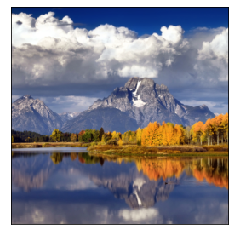

In [8]:
plot_image(plt.gcf().gca(), img)

In [11]:
onnx_session= onnxrt.InferenceSession('gdrive/MyDrive/dls/cycle_gan/generator.onnx')
onnx_inputs= {onnx_session.get_inputs()[0].name: np.array(img.unsqueeze(0))}
onnx_output = onnx_session.run(None, onnx_inputs)
out = onnx_output[0]

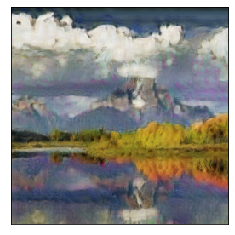

In [12]:
plot_image(plt.gcf().gca(), out.squeeze())